In [1]:
# import all relevant libraries for creation of model for brain stroke
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, \
                            plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report, \
                            ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


In [43]:
# perform initial inspection of dataset
df = pd.read_csv('brain_stroke.csv')

In [44]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


We can see that there are both categorical and numerical features, so we will need to perform feature engineering to get all the columns in the format that we would like. 

In [45]:
df.shape

(4981, 11)

In [46]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [47]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Modeling Set Up


In [48]:
# Create our sub pipelines for numeric and categorial data

subpipe_num = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False,
                                                    handle_unknown='ignore'))])

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [1,7,8]), 
                                     ('subpipe_cat', subpipe_cat, [0,2,3,4,5,6,9])])

In [49]:
X = df.drop(columns='stroke')
y = df['stroke']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [51]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=24) 

In [52]:
CT.fit(X_train_fin)

ColumnTransformer(transformers=[('subpipe_num',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 [1, 7, 8]),
                                ('subpipe_cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [0, 2, 3, 4, 5, 6, 9])])

In [53]:
X_train_fin = CT.transform(X_train_fin)
X_val = CT.transform(X_val)
X_test = CT.transform(X_test)

In [58]:
X_train_fin.shape


(3187, 21)

In [55]:
X_val.shape

(797, 21)

In [56]:
X_test.shape

(997, 21)

# Modeling


## Dummy Model

In [40]:
dummy = DummyClassifier(strategy='most_frequent')

In [59]:
dummy.fit(X_train_fin, y_train_fin)

DummyClassifier(strategy='most_frequent')

In [61]:
dummy.score(X_val, y_val)

0.9560853199498118

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


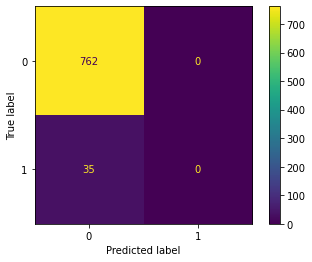

In [63]:
plot_confusion_matrix(dummy, X_val, y_val);

## Logistic Regression

In [74]:
lr = LogisticRegression(random_state=24)

In [75]:
lr.fit(X_train_fin, y_train_fin)

LogisticRegression(random_state=24)

In [76]:
lr.score(X_val, y_val)

0.9560853199498118

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


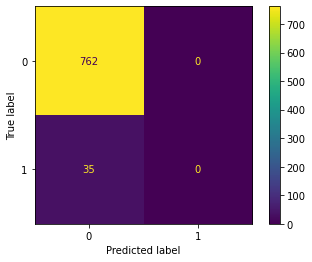

In [77]:
plot_confusion_matrix(lr, X_val, y_val)

## Decision Tree

In [78]:
dtc = DecisionTreeClassifier(random_state=24)

In [79]:
dtc.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(random_state=24)

In [82]:
dtc.score(X_train_fin, y_train_fin)

1.0

In [80]:
dtc.score(X_val, y_val)

0.903387703889586

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


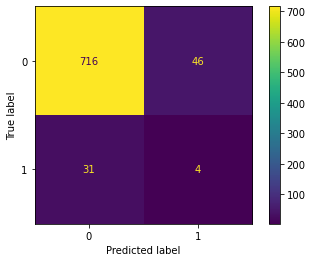

In [81]:
plot_confusion_matrix(dtc, X_val, y_val)

In [83]:
rfc = RandomForestClassifier(random_state=24)

In [84]:
rfc.fit(X_train_fin, y_train_fin)

RandomForestClassifier(random_state=24)

In [85]:
rfc.score(X_train_fin, y_train_fin)

1.0

In [86]:
rfc.score(X_val, y_val)

0.9560853199498118